In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primal_VPINN import *
from NN_library.train_dual_VPINN import *
from matplotlib.tri import Triangulation
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_grid(129, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 129**2)

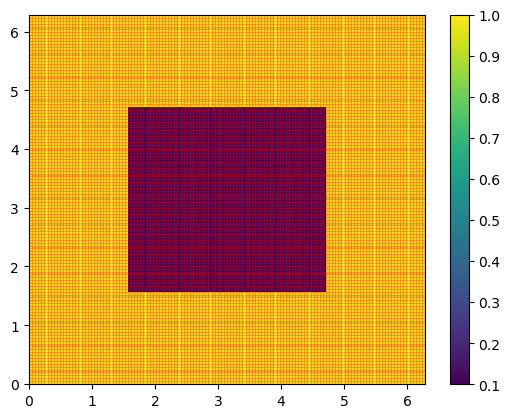

In [3]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    a = np.where((x>np.pi/2)&(x<3*np.pi/2)&(y>np.pi/2)&(y<3*np.pi/2), 0.1, 1)
    return a

def A(x):
    a = torch.where((x[:,0]>torch.pi/2)&(x[:,0]<3*torch.pi/2)&(x[:,1]>torch.pi/2)&(x[:,1]<3*torch.pi/2), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    a = torch.where((x[:,0]>torch.pi/2)&(x[:,0]<3*torch.pi/2)&(x[:,1]>torch.pi/2)&(x[:,1]<3*torch.pi/2), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

eps=10

def A_interp(x): 
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a.view(-1,1,1) * I
    return A

def A_interp_inv(x):  
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = 1/a.view(-1,1,1) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.1, c='r')

# Test functions

## NN-based

In [5]:
N_test = 100
torch.manual_seed(0)
test_functions = [PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L).to(dev) for i in range(N_test)]

In [6]:
# compute G if needed
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(dev)
x = x.to(dev).requires_grad_(True)

G = torch.zeros((N_test, N_test))
g_test = []
for i in range(N_test):
    y_test = test_functions[i](x)
    grad_test = torch.autograd.grad(
                outputs=y_test, inputs=x,
                grad_outputs=torch.ones_like(y_test)
            )[0]
    g_test.append(grad_test.detach())

#for i in range(N_test):
    #for j in range(i, N_test):
        #intgr = compute_int(areas, tri, g_test[i], g_test[j])
        #G[i,j] = intgr
        #G[j,i] = intgr

for i in range(N_test):
        intgr = compute_int(areas, tri, g_test[i], g_test[i]).detach()
        G[i,i] = intgr

torch.save(G, "G_primal_65.pt")
G_inv = torch.linalg.inv(G).to(dev)

In [9]:
G = torch.load("G_primal_65.pt")[:N_test,:N_test]
G_inv = torch.linalg.inv(G).to(dev)

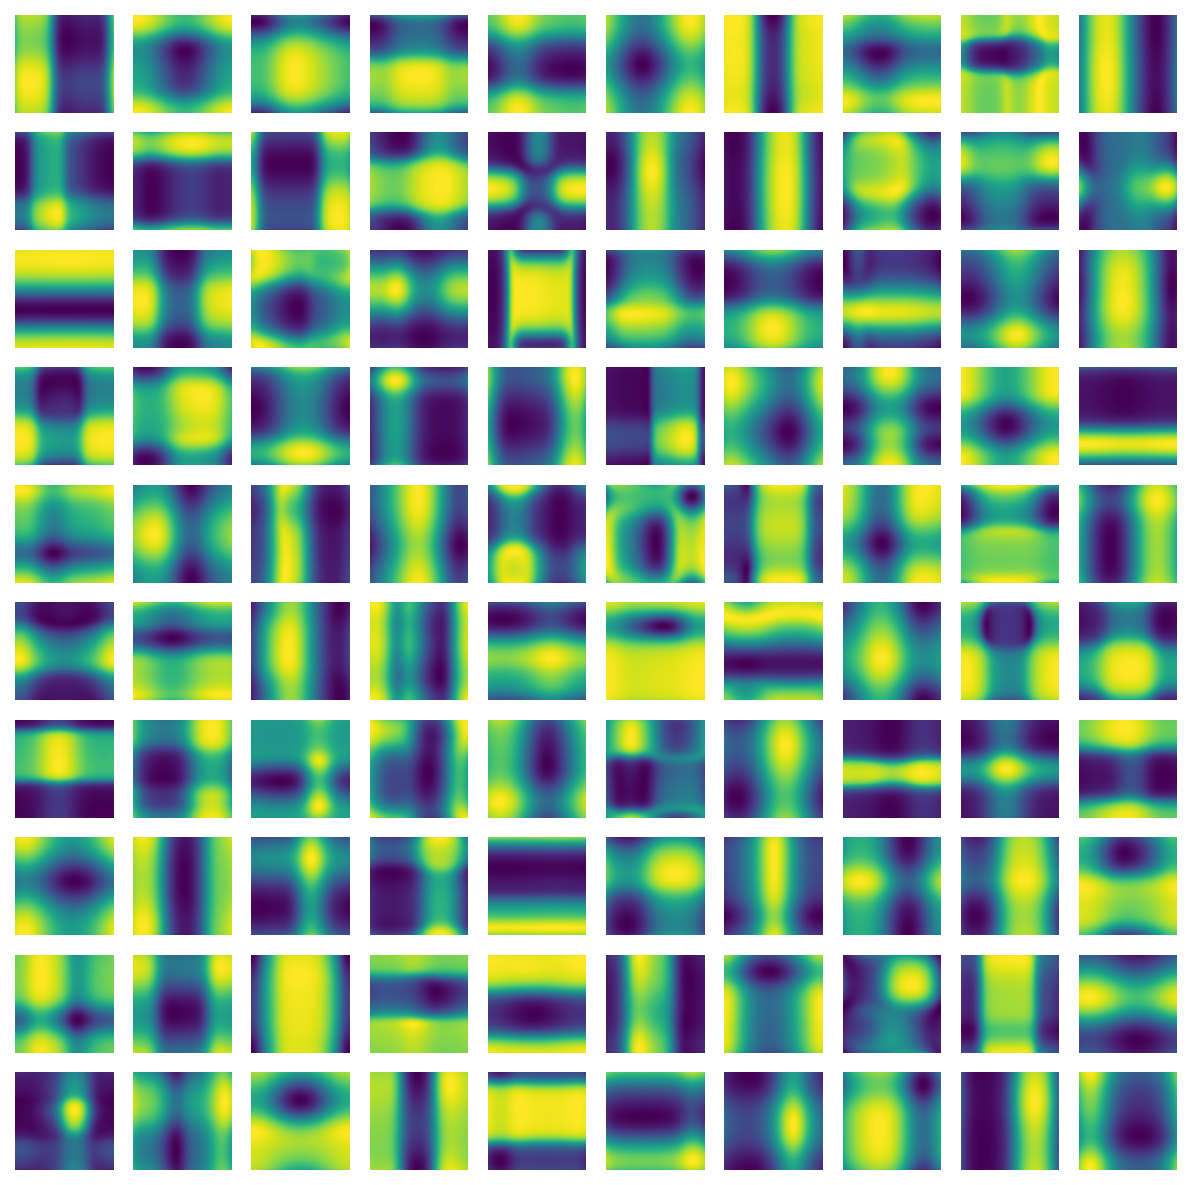

In [14]:
fig, axs = plt.subplots(nrows=10, ncols=N_test//10, figsize=(N_test//10,10), dpi=150)
for i in range(len(test_functions)):
    axs.flat[i].pcolormesh(XY[0], XY[1], test_functions[i](grid_data).reshape(N, N).cpu().detach())
    axs.flat[i].set_axis_off()

# Primal PINN

In [ ]:
net_primal = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_primal.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 1e-4, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VNPINN_primal_interp_{total_params}_{N_test}'}

Number of parameters: 65


In [ ]:
net_primal = load_network(net_primal, args['name']+'_39999', args)
net_primal = net_primal.to(dev)

In [44]:
losses_train, losses_val = train_primal(net_primal, loaders, args, A, H1, test_functions, G_inv, L)

Epoch: 0 mean train loss:  5.24746475e+01, mean val. loss:  7.84321249e-01
Epoch: 1 mean train loss:  5.24565735e+01, mean val. loss:  7.84314632e-01
Epoch: 2 mean train loss:  5.24385529e+01, mean val. loss:  7.84308136e-01
Epoch: 3 mean train loss:  5.24205780e+01, mean val. loss:  7.84301519e-01
Epoch: 4 mean train loss:  5.24026642e+01, mean val. loss:  7.84294963e-01
Epoch: 5 mean train loss:  5.23848000e+01, mean val. loss:  7.84288466e-01
Epoch: 6 mean train loss:  5.23669968e+01, mean val. loss:  7.84281969e-01
Epoch: 7 mean train loss:  5.23492432e+01, mean val. loss:  7.84275472e-01
Epoch: 8 mean train loss:  5.23315468e+01, mean val. loss:  7.84268916e-01
Epoch: 9 mean train loss:  5.23139076e+01, mean val. loss:  7.84262478e-01
Epoch: 10 mean train loss:  5.22963257e+01, mean val. loss:  7.84256041e-01
Epoch: 11 mean train loss:  5.22788010e+01, mean val. loss:  7.84249604e-01
Epoch: 12 mean train loss:  5.22613297e+01, mean val. loss:  7.84243107e-01
Epoch: 13 mean train l

In [ ]:
np.save(f'NN_library/training_data/square/VNPINN_primal_interp_{total_params}_{N_test}', np.vstack([losses_train, losses_val]))

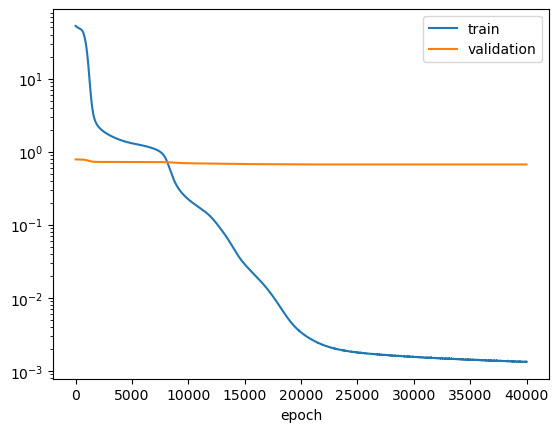

In [46]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [47]:
U1 = net_primal(grid_data).detach().cpu()
error_1, _ = PDE_loss(grid_data, net_primal, A, H1)

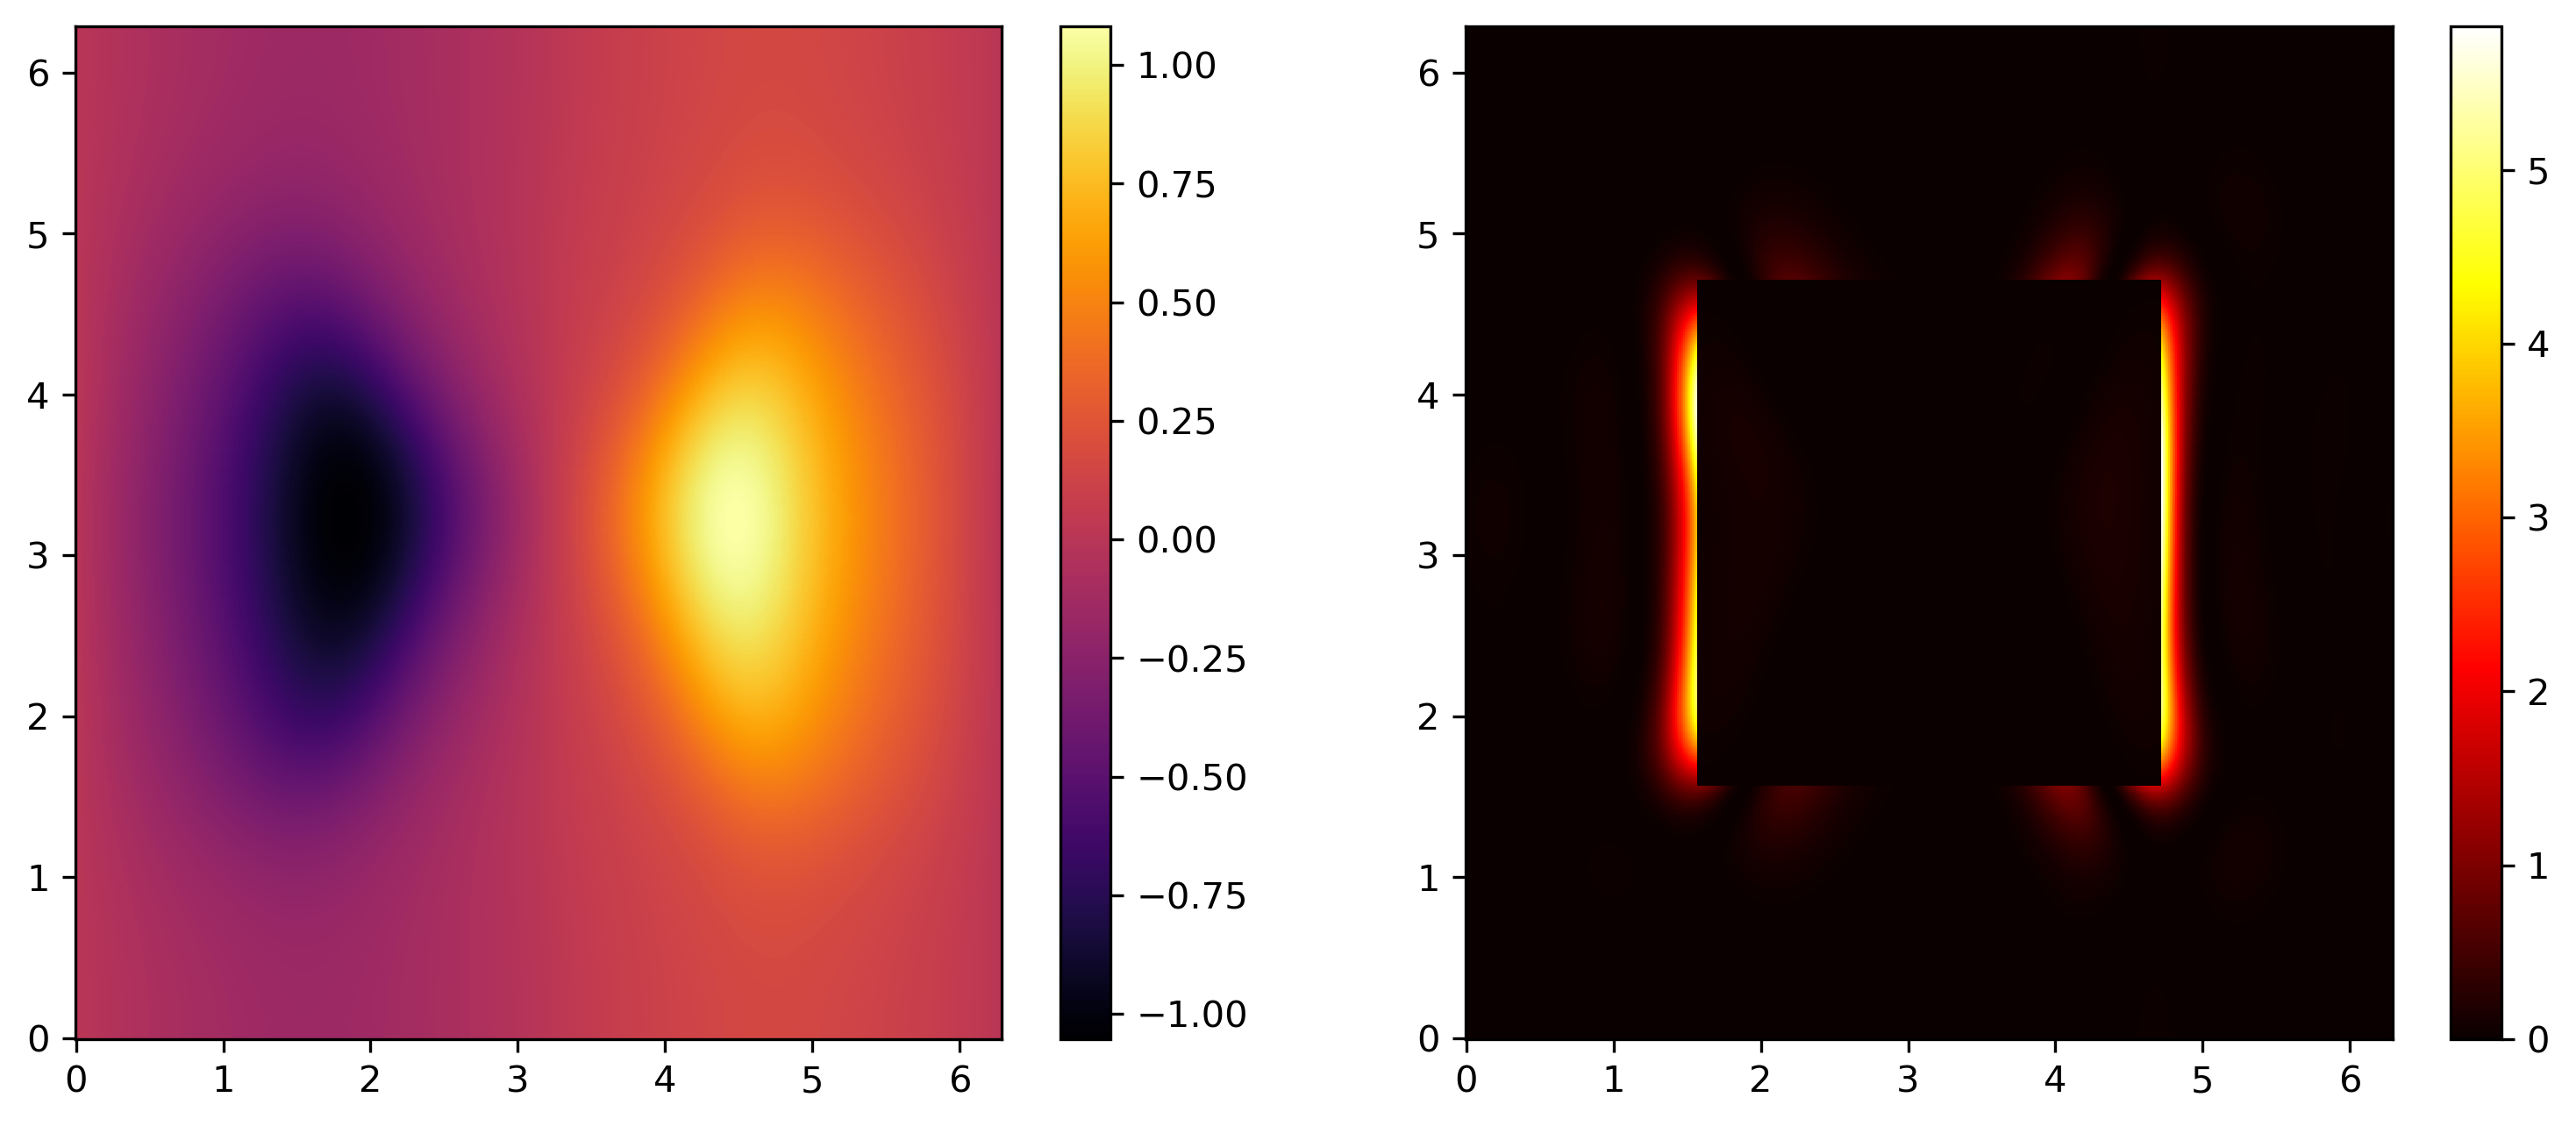

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])

In [ ]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])

_, q = PDE_loss(x, net_primal, A, H1)
bound = compute_bound(areas, tri, q, L).detach()[0].item()
print(bound)

np.save(f'bounds/square/A_u_VNPINN_interp_{total_params}_{N_test}.npy', bound)

0.6682454347610474


# Dual PINN

In [7]:
net_dual = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_dual.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VNPINN_dual_interp_{total_params}_{N_test}'}

Number of parameters: 65


In [14]:
net_dual = load_network(net_dual, f'NN_library/PINN/square/PINN_dual_{total_params}'+'_39999', args)
net_dual = net_dual.to(dev)

In [12]:
net_dual = load_network(net_dual, args['name']+'_39999', args)
net_dual = net_dual.to(dev)

In [17]:
losses_train, losses_val = train_dual(net_dual, loaders, args, A_interp_inv, H1, test_functions, G_inv, L)

Epoch: 0 mean train loss:  5.02319107e+01, mean val. loss:  6.98854566e-01
Epoch: 1 mean train loss:  4.72040520e+01, mean val. loss:  6.95239305e-01
Epoch: 2 mean train loss:  4.43235703e+01, mean val. loss:  6.91699803e-01
Epoch: 3 mean train loss:  4.15866089e+01, mean val. loss:  6.88249946e-01
Epoch: 4 mean train loss:  3.89909439e+01, mean val. loss:  6.84897900e-01
Epoch: 5 mean train loss:  3.65337334e+01, mean val. loss:  6.81653380e-01
Epoch: 6 mean train loss:  3.42099724e+01, mean val. loss:  6.78526521e-01
Epoch: 7 mean train loss:  3.20161285e+01, mean val. loss:  6.75526202e-01
Epoch: 8 mean train loss:  2.99481888e+01, mean val. loss:  6.72654748e-01
Epoch: 9 mean train loss:  2.80007362e+01, mean val. loss:  6.69907749e-01
Epoch: 10 mean train loss:  2.61702995e+01, mean val. loss:  6.67280972e-01
Epoch: 11 mean train loss:  2.44522705e+01, mean val. loss:  6.64768875e-01
Epoch: 12 mean train loss:  2.28423958e+01, mean val. loss:  6.62366450e-01
Epoch: 13 mean train l

In [ ]:
np.save(f'NN_library/training_data/square/VNPINN_dual_interp_{total_params}_{N_test}', np.vstack([losses_train, losses_val]))

Using device: cuda


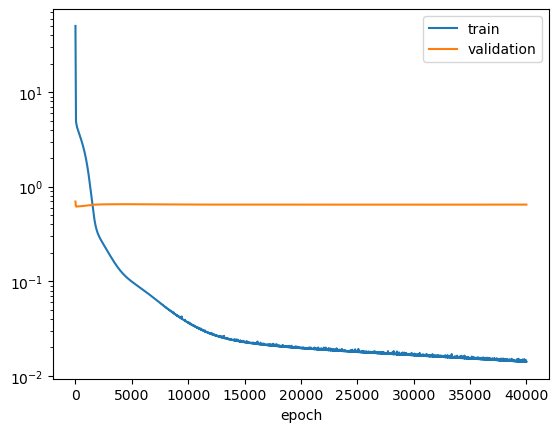

In [18]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [19]:
U2 = net_dual(grid_data).detach().cpu()
error_2, _ = PDE_loss_dual(grid_data, net_dual, A_inv, H1)

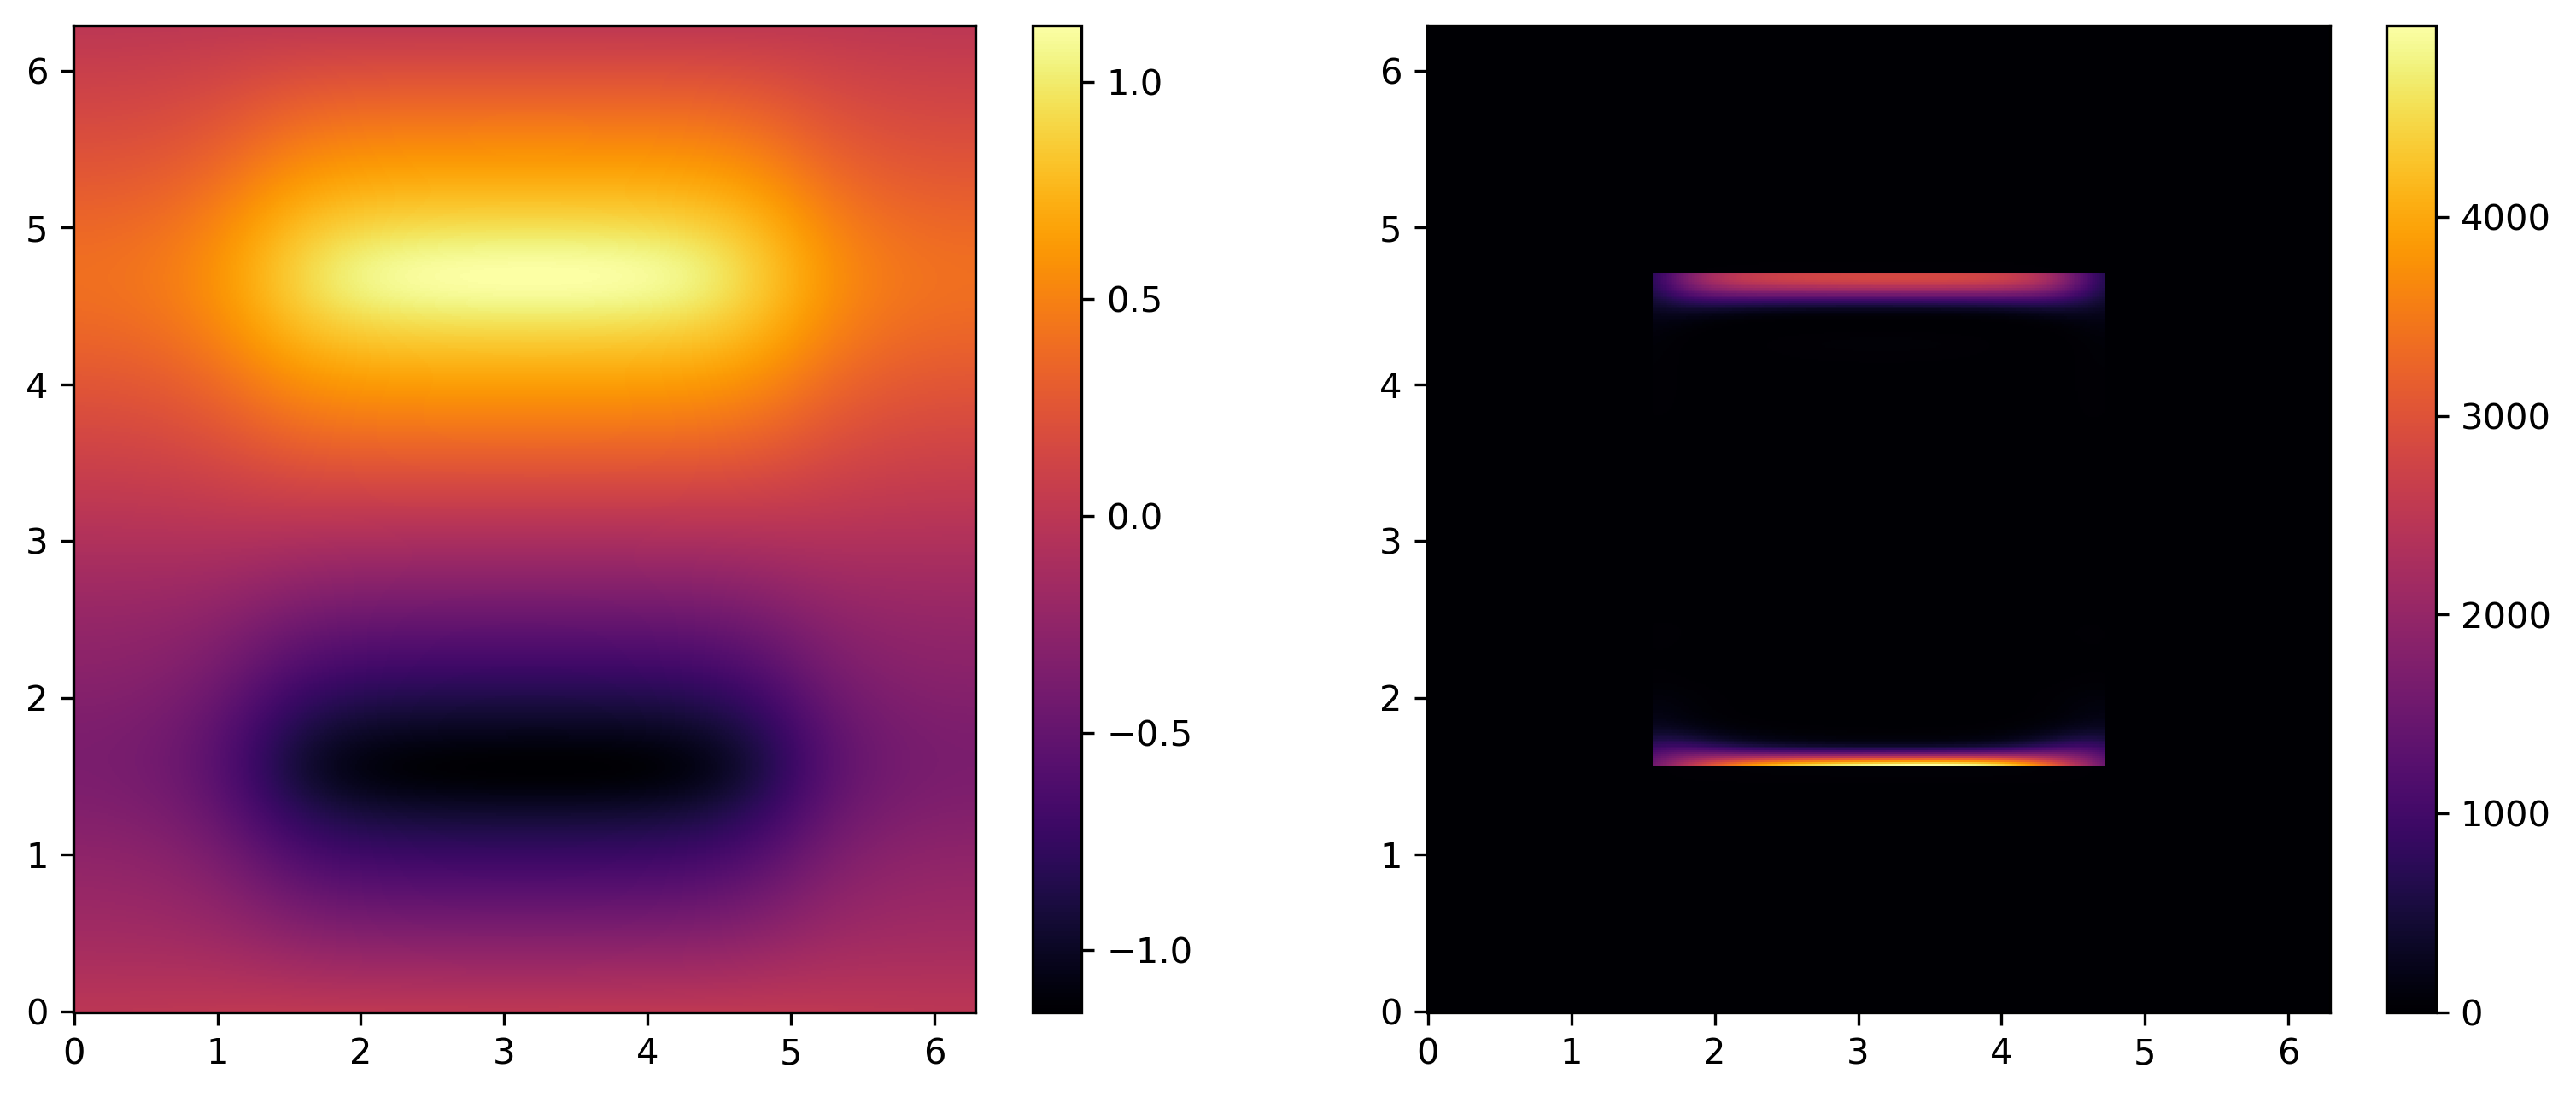

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])

In [21]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])

_, q = PDE_loss_dual(x, net_dual, A_interp_inv, H1)
bound = compute_bound(areas, tri, q, L).detach()
bound_inv = bound[0] / (bound[0]**2 - bound[1]**2)
print(bound_inv)

np.save(f'bounds/square/A_l_VNPINN_interp_{total_params}_{N_test}.npy', bound_inv.item())

tensor(0.6483, device='cuda:0')
